In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score

In [2]:
df = pd.read_csv('../../datasets/model.csv', index_col = [0])

### Explain each variable choice

In [3]:
X = df[['ydstogo', 'run', 'td_prob', 'goal_to_go']]
y = df['4th_down_conversion']

# Confusion Matrices and ROCs of Random Forest Classification

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [5]:
rf = RandomForestClassifier()

In [6]:
rf.fit(X_train, y_train)

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [7]:
rf.score(X_train, y_train)

0.9427694025683976

In [8]:
rf.score(X_test, y_test)

0.5661641541038526

# Gridsearch for best params

In [9]:
rf = RandomForestClassifier()
rf_params = {
    'n_estimators': [4, 5, 6, 7],
    'max_depth': [2, 3, 4, 5],
    'min_samples_split': [4, 5, 6, 7]
}
gs = GridSearchCV(rf, param_grid=rf_params)
gs.fit(X_train, y_train)
print(gs.best_score_)
gs.best_params_

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


0.6306532663316583


{'max_depth': 4, 'min_samples_split': 7, 'n_estimators': 4}

In [10]:
gs.score(X_train, y_train)

0.6340033500837521

In [11]:
gs.score(X_test, y_test)

0.6515912897822446

In [12]:
preds = gs.predict(X_test)

In [13]:
confusion_matrix(y_test, preds)  

array([[409, 229],
       [187, 369]])

In [14]:
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

In [15]:
# What is the specificity of our test set?

spec = tn / (tn + fp)

# sPecificity = TN / all negatives = TN / (TN + FP)

print(f'Specificity: {round(spec,4)}')

Specificity: 0.6411


In [16]:
# What is the sensitivity of our test set?

sens = tp / (tp + fn)

# seNsitivity = TP / all positives = TP / (TP + FN)

print(f'Sensitivity: {round(sens,4)}')

Sensitivity: 0.6637


In [17]:
# What is the accuracy of our test set?
acc = (tp + tn) / (tp + tn + fp + fn)

print(f'Accuracy: {round(acc,4)}')

Accuracy: 0.6516


In [18]:
pred_proba = [i[1] for i in gs.predict_proba(X_test)]

pred_df = pd.DataFrame({'true_values': y_test,
                        'pred_probs':pred_proba})

In [19]:
pred_df.head()

,true_values,pred_probs
2724,1.0,0.203289
44543,1.0,0.661885
257237,1.0,0.445747
300830,0.0,0.576704
376804,1.0,0.576704


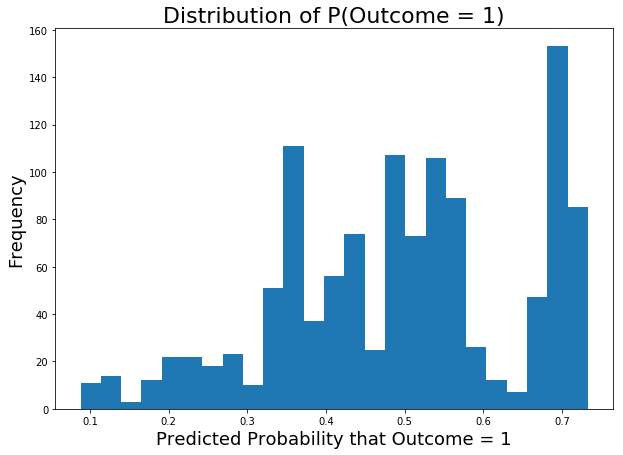

In [20]:
# Create figure.
plt.figure(figsize = (10,7))

# Create histogram of observations.
plt.hist(pred_df['pred_probs'], bins=25)

# Label axes.
plt.title('Distribution of P(Outcome = 1)', fontsize=22)
plt.ylabel('Frequency', fontsize=18)
plt.xlabel('Predicted Probability that Outcome = 1', fontsize=18)
plt.savefig('../../images/ranfor/distribution_1.png');

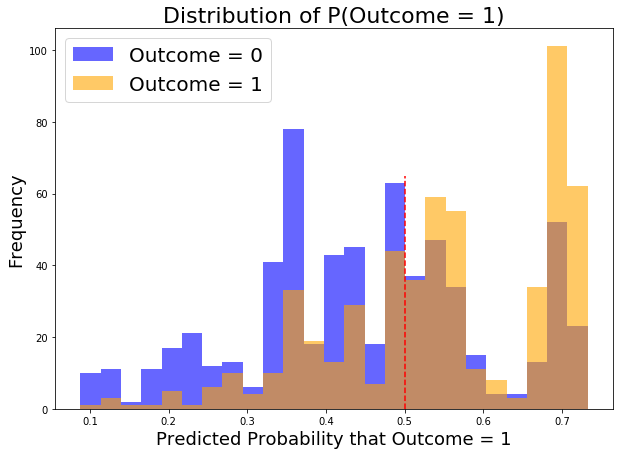

In [21]:

# Create figure.
plt.figure(figsize = (10,7))

# Create two histograms of observations.
plt.hist(pred_df[pred_df['true_values'] == 0]['pred_probs'],
         bins=25,
         color='b',
         alpha = 0.6,
         label='Outcome = 0')
plt.hist(pred_df[pred_df['true_values'] == 1]['pred_probs'],
         bins=25,
         color='orange',
         alpha = 0.6,
         label='Outcome = 1')

# Add vertical line at P(Outcome = 1) = 0.5.
plt.vlines(x=0.5,
           ymin = 0,
           ymax = 65,
           color='r',
           linestyle = '--')

# Label axes.
plt.title('Distribution of P(Outcome = 1)', fontsize=22)
plt.ylabel('Frequency', fontsize=18)
plt.xlabel('Predicted Probability that Outcome = 1', fontsize=18)

# Create legend.
plt.legend(fontsize=20)
plt.savefig('../../images/ranfor/distribution_2.png')

In [22]:
roc_auc_score(pred_df['true_values'], pred_df['pred_probs'])

0.6926391488689926

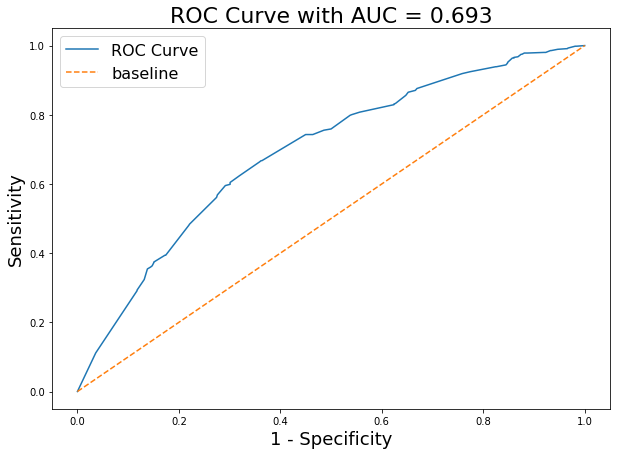

In [23]:
# Create figure.
plt.figure(figsize = (10,7))

# Create threshold values. (Dashed red line in image.)
thresholds = np.linspace(0, 1, 200)

# Define function to calculate sensitivity. (True positive rate.)
def TPR(df, true_col, pred_prob_col, threshold):
    true_positive = df[(df[true_col] == 1) & (df[pred_prob_col] >= threshold)].shape[0]
    false_negative = df[(df[true_col] == 1) & (df[pred_prob_col] < threshold)].shape[0]
    return true_positive / (true_positive + false_negative)
    
# Define function to calculate 1 - specificity. (False positive rate.)
def FPR(df, true_col, pred_prob_col, threshold):
    true_negative = df[(df[true_col] == 0) & (df[pred_prob_col] <= threshold)].shape[0]
    false_positive = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
    return 1 - (true_negative / (true_negative + false_positive))
    
# Calculate sensitivity & 1-specificity for each threshold between 0 and 1.
tpr_values = [TPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]
fpr_values = [FPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]

# Plot ROC curve.
plt.plot(fpr_values, # False Positive Rate on X-axis
         tpr_values, # True Positive Rate on Y-axis
         label='ROC Curve')

# Plot baseline. (Perfect overlap between the two populations.)
plt.plot(np.linspace(0, 1, 200),
         np.linspace(0, 1, 200),
         label='baseline',
         linestyle='--')

# Label axes.
plt.title(f'ROC Curve with AUC = {round(roc_auc_score(pred_df["true_values"], pred_df["pred_probs"]),3)}', fontsize=22)
plt.ylabel('Sensitivity', fontsize=18)
plt.xlabel('1 - Specificity', fontsize=18)

# Create legend.
plt.legend(fontsize=16)
plt.savefig('../../images/ranfor/roc.png')